In [1]:
#참조 : https://wikidocs.net/214229

In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path='/content/drive/MyDrive/Colab Notebooks/bert_240526_고수의클래스연계/data_folder'
!ls '/content/drive/MyDrive/Colab Notebooks/bert_240526_고수의클래스연계/data_folder'

Mounted at /content/drive
corpus2.csv  corpus2_temp.csv  corpus2_test100_answer.csv  corpus2_test100.csv	corpus2_train.csv


In [42]:
import pandas as pd
train = pd.read_csv(folder_path+'/'+'corpus2_train.csv', encoding='UTF-8')
test30 = pd.read_csv(folder_path+'/'+'corpus2_test100.csv', encoding='UTF-8')

In [43]:
display(train.head())
display(test30.head())

,감정,문장
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


,문장
0,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [5]:
#@title 환경설정

# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import sys

from IPython.display import clear_output
clear_output(wait=True)

## 관련 라이브러스 설치
import tensorflow as tf

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import keras
# from keras.preprocessing.sequence import pad_sequences  # path removed
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
TensorFlow version :  2.17.0
Keras version :  3.4.1


In [44]:
# 선택하여 열 이름 변경하기
train=train.rename(columns={'감정':'label','문장':'text'})


In [45]:
test30=test30.rename(columns={'감정':'label','문장':'text'})

In [46]:
train.head()

,label,text
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


In [30]:
test30.head()

,text
0,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [32]:
print(train["text"].groupby([train["label"]]).count())

label
기쁨    6126
당황    8731
분노    9132
불안    9303
상처    9122
슬픔    9116
Name: text, dtype: int64


In [10]:
'''
train.loc[train.label=='기쁨', 'label']='0'
train.loc[train.label=='당황', 'label']='1'
train.loc[train.label=='분노', 'label']='2'
train.loc[train.label=='불안', 'label']='3'
train.loc[train.label=='상처', 'label']='4'
train.loc[train.label=='슬픔', 'label']='5'
'''

In [23]:
'''
test30.loc[test30.label=='기쁨', 'label']='0'
test30.loc[test30.label=='당황', 'label']='1'
test30.loc[test30.label=='분노', 'label']='2'
test30.loc[test30.label=='불안', 'label']='3'
test30.loc[test30.label=='상처', 'label']='4'
test30.loc[test30.label=='슬픔', 'label']='5'
'''

"\ntest30.loc[test30.label=='기쁨', 'label']='0'\ntest30.loc[test30.label=='당황', 'label']='1'\ntest30.loc[test30.label=='분노', 'label']='2'\ntest30.loc[test30.label=='불안', 'label']='3'\ntest30.loc[test30.label=='상처', 'label']='4'\ntest30.loc[test30.label=='슬픔', 'label']='5'\n"

In [47]:
#또는
# 라벨와 클래스을 매핑 작업
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train['label'] = encoder.fit_transform(train['label'])
#test30['label'] = encoder.transform(test30['label'])
encoder.classes_

array(['기쁨', '당황', '분노', '불안', '상처', '슬픔'], dtype=object)

In [50]:
encoder.inverse_transform([1])[0]

'당황'

In [ ]:
'''
from sklearn.preprocessing import LabelEncoder

# 예시 데이터
train_labels = ['male', 'female', 'female', 'male']

# LabelEncoder를 사용해 라벨을 숫자로 인코딩
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(train_labels)

# 인코딩된 결과 확인
print("Encoded labels:", encoded_labels)
print("Classes:", encoder.classes_)

# 디코딩: 숫자를 다시 원래의 라벨로 변환
decoded_labels = encoder.inverse_transform(encoded_labels)

# 디코딩된 결과 확인
print("Decoded labels:", decoded_labels)
'''

In [51]:
display(train.tail())
display(test30.tail())

,label,text
51525,1,미래를 위해 박사 과정을 준비하고 있는데 금전과 시간적인 문제로 남편에게 죄책감이 들어.
51526,2,점점 생계를 책임지는 것이 부담되고 버거워. 이 정도밖에 안 되는 내가 너무 싫어.
51527,3,상사가 시킨 업무가 수행하기 너무 어려워서 스트레스를 받고 있어.
51528,5,이제 뭘 해도 힘들어. 벌써 갱년기인 것 같아서 무기력하고 우울해.
51529,2,나이를 먹으니 취업도 안 되고 사회에 쓸모없는 인간이 된 것 같아서 괴로워.


,text
95,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.
96,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.
97,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.
98,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.
99,남편과 결혼한 지 사십 년이야. 이제 사람 만나는 것도 버겁고 알던 사람도 점점 사라져.


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51530 entries, 0 to 51529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   51530 non-null  int64 
 1   text    51530 non-null  object
dtypes: int64(1), object(1)
memory usage: 805.3+ KB


In [53]:
## label 값을 숫자로 전환
#train['label'] = train['label'].apply(pd.to_numeric)
#test30['label'] = test30['label'].apply(pd.to_numeric)

In [54]:
train.info()
test30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51530 entries, 0 to 51529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   51530 non-null  int64 
 1   text    51530 non-null  object
dtypes: int64(1), object(1)
memory usage: 805.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [55]:
#@title 훈련 데이터 비율 선택하기

훈련데이터비율 = 0.8  #param ['0.9', '0.8', '0.7', '0.6'] 나머지는 검증 데이터

## 훈련데이터와 테스트데이터로 분리
#train=train.sample(frac=훈련데이터비율,random_state=200)
#test=train.drop(train.index)
#train=train.copy()

train.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행... 특수문자는 제거
train['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train = train.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train))

'''
test.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))
'''

전처리 후 훈련용 샘플의 개수 : 51501


'\ntest.drop_duplicates(subset = [\'text\'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거\ntest[\'text\'] = test[\'text\'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행\ntest[\'text\'].replace(\'\', np.nan, inplace=True) # 공백은 Null 값으로 변경\ntest = test.dropna(how=\'any\') # Null 값 제거\nprint(\'전처리 후 테스트용 샘플의 개수 :\',len(test))\n'

In [56]:
#@title 학습 데이터 처리 - BERT형식으로 변환

# 리뷰 문장 추출
sentences = train['text']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])


# 라벨 추출
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)


##### 원본 데이터 #####
0                            일은 왜 해도 해도 끝이 없을까? 화가 난다.
1       이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2    회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3    직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4                얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
5        직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.
6             성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.
7                        퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.
8            졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.
9                             요즘 직장생활이 너무 편하고 좋은 것 같아!
Name: text, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] 일은 왜 해도 해도 끝이 없을까? 화가 난다. [SEP]', '[CLS] 이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나. [SEP]', '[CLS] 회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스트레스 받아.  [SEP]', '[CLS] 직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 섭섭해. [SEP]', '[CLS] 얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나. [SEP]', '[CLS] 직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨. [SEP]', '[CLS] 성인인데도 진로를 아직도 못 정

In [57]:
#@title 학습 데이터 처리 - BERT로 토큰화하기

bert모델 = "bert-base-multilingual-cased"

#"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
#"bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
#"bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
#"bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
#"bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
#"bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
#"bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
#"bert-base-german-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
#"bert-large-uncased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
#"bert-large-cased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
#"bert-large-uncased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
#"bert-large-cased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
#"bert-base-cased-finetuned-mrpc": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
#"bert-base-german-dbmdz-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
#"bert-base-german-dbmdz-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
#"bert-base-japanese": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
#"bert-base-japanese-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
#"bert-base-japanese-char": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
#"bert-base-japanese-char-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
#"bert-base-finnish-cased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
#"bert-base-finnish-uncased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",


# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[CLS] 일은 왜 해도 해도 끝이 없을까? 화가 난다. [SEP]
['[CLS]', '일', '##은', '왜', '해', '##도', '해', '##도', '끝', '##이', '없', '##을', '##까', '?', '화', '##가', '난', '##다', '.', '[SEP]']


문장의 최대 길이 : 168
문장의 평균 길이 : 47.19723888856527


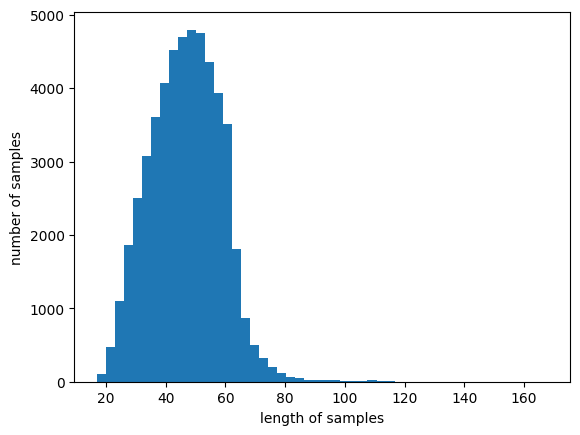

전체 샘플 중 길이가 60 이하인 샘플의 비율: 87.53422263645366


In [58]:
#@title 전처리를 위한 문장 길이 조회

## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = "60" # "128" 대다수의 문장 길이를 포함하는 60자 정도로 텍스트 문장 길이를 지정한다
최대길이 = int(최대길이)

print('문장의 최대 길이 :',max(len(l) for l in sentences))
## 문장의 최대 길이는 가장 긴 문장의 길이를 의미합니다.

print('문장의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 문장의 평균 길이는 문장 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 문장의 전체 분포를 볼 수 있습니다.
## 대다수의 문장이 50자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences)

## max_leb(문장 최대 길이)가 128일때 선택되는 전체 데이터량을 의미합니다.
## 현재값은 95.92로 대략 6%를 제외한 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [59]:
#@title 토큰 인덱스 변환, 패딩 및 어텐션 마스크 세팅

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해줍니다.
## 물론 어떤 리뷰는 128자 이상이기도 합니다. 하지만 효율성을 위해서 고정해줍니다.
## MAX_LEN을 256, 512 등 더 크게 변경할 수도 있습니다. 그러면 처리 시간이 더 걸립니다. 대신 정확도는 상승합니다.
## 반대로 MAX_LEN을 64, 32 등 더 작게 변경할 수도 있습니다. 그러면 처리 시간은 짦아지고, 정확도는 줄어듭니다.
## MAX_LEN에 "정답"은 없습니다. 적절한 길이를 선택해야 합니다.

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
## 패딩이란 MAX_LEN보다 짦은 문장에 적용합니다. 문장 길이가 120이라면 8개가 패딩으로 채워지게 됩니다.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids[0])

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[   101   9641  10892   9596   9960  12092   9960  12092   8977  10739
   9555  10622 118671    136   9993  11287   8984  11903    119    102
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [60]:
#@title 훈련데이터와 검증 데이터 분리 및 배치 세팅

검증데이터비율 = "0.2"

배치크기 = "64"
배치크기 = int(배치크기)


# 훈련셋과 검증셋으로 분리
validation_size = 검증데이터비율
## 훈련셋과 검증셋은 9:1로 분리해줍니다. 숫자를 변경하면 비율을 변경할 수 있습니다.

random_state = 1
## 컴퓨터에서의 분리는 시간값을 토대로 하는 랜덤입니다.
## 하지만 완전히 랜덤으로 하면 학습마다 다른 결과가 나오는 문제가 발생합니다.
## 이를 통제하기 위해서 랜덤 시작값을 세팅해줍니다.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=random_state,
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=random_state,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])


# 배치 사이즈
batch_size = 배치크기

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##### 훈련 텍스트의 bert embedding값 #####
tensor([  101,  9288, 10739,  9521,  9685, 16985,   119,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
##### 훈련 텍스트의 label 값 #####
tensor(3)
##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
##### 검증 텍스트의 bert embedding값 #####
tensor([   101,  66402,   9694,  80331,  20729,   9434,  14801,  10739,  62548,
          9141,  65164,  12424,

In [61]:
len(train_data)

46350

In [62]:
len(validation_data)

5151

In [64]:
#여기는 나온 정답을 CSV에 올리면 됨 --> 이건 패스..

#@title 테스트 데이터 처리(훈련데이터와 동일)

# 리뷰 문장 추출
sentences = test30['text']

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
#labels = test30['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)


AssertionError: Size mismatch between tensors

In [65]:
#@title GPU 세팅

## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [66]:
#@title 딥러닝 모델 세팅

# 분류를 위한 BERT 모델 생성
## 이미 bert를 통한 분류 모델이 만들어져 있습니다. 모델을 불러오기만 하면 됩니다.
## num_labels를 통해서 분류 갯수를 지정해줍니다. 저희는 긍정-부정의 2개 분류이기에 2입니다.

분류개수 = "6"  #['2', '3', '4', '5']
# 기쁨 당황 분노 불안 상처 슬픔
분류개수 = int(분류개수)

epochs수 = "3"  #['2', '3', '4', '5']
epochs수 = int(epochs수)

model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류개수)
model.cuda()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = epochs수

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [67]:
#@title 딥러닝 모델 간략 보기

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [68]:
#@title 딥러닝 학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))

    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


## 본격적으로 딥러닝 학습을 수행하게 됩니다.
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다.
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

from tqdm.notebook import tqdm

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 / 매 40  batch 마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        # 그래디언트 초기화
        model.zero_grad()

        # Forward 수행
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # 총 로스 계산
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행으로 그래디언트 계산
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # 그래디언트 클리핑
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # 스케줄러로 학습률 감소
        # Update the learning rate.
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss  / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   500  of    725.    Elapsed: 0:04:46.

  Average training loss: 1.39
  Training epcoh took: 0:06:55

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.21
  Validation took: 0:00:15

======== Epoch 2 / 3 ========
Training...
  Batch   500  of    725.    Elapsed: 0:04:48.

  Average training loss: 1.17
  Training epcoh took: 0:06:57

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.17
  Validation took: 0:00:15

======== Epoch 3 / 3 ========
Training...
  Batch   500  of    725.    Elapsed: 0:04:48.

  Average training loss: 1.10
  Training epcoh took: 0:06:57

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.17
  Validation took: 0:00:15

Training complete!
Total training took 0:21:34 (h:mm:ss)


       Training Loss  Valid. Loss  Training. Accur  Valid. Accur. Training Time Validation Time
epoch                                                                                          
1           1.385211     1.210604         0.532003       0.532003       0:06:55         0:00:15
2           1.171845     1.171329         0.552463       0.552463       0:06:57         0:00:15
3           1.098476     1.174534         0.554379       0.554379       0:06:57         0:00:15


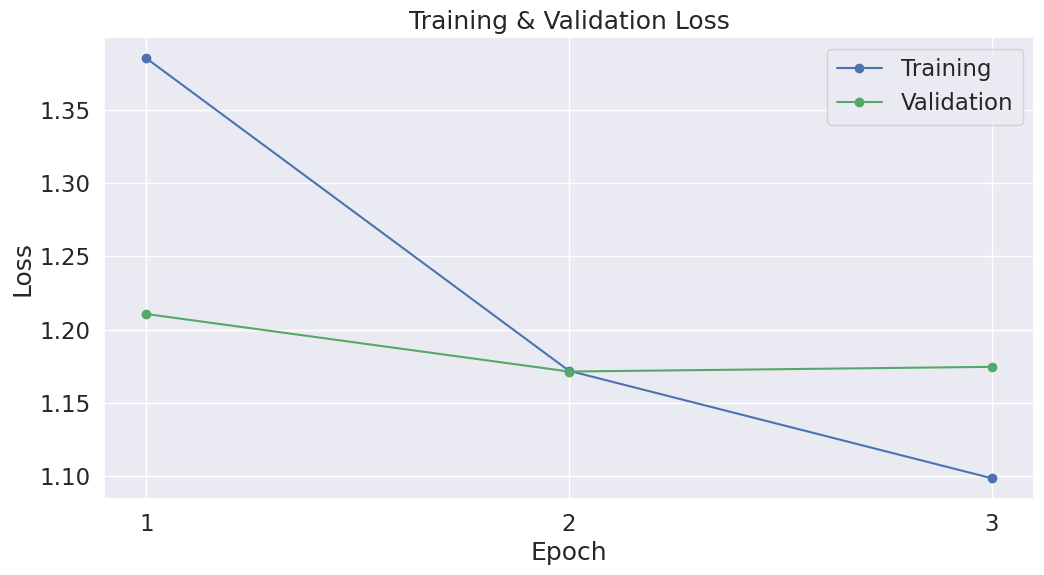

In [69]:
#@title 딥러닝 학습 간단 보기

import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)  # deprecated
pd.set_option("display.max_columns", 100)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats.to_string())


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks([1, 2, 3, 4])
plt.xticks([i for i in range(1, epochs수+1)])

plt.show()

In [ ]:
#@title 딥러닝 학습 평가하기 __ SKIP 자동으로 현재 모델로 테스트 데이터의 점수를 매겨주고 정확도를 계산해줌..

라벨링 = ['bosu','jinbo']  # @ param


# import
import time

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()


# Tracking variables
predictions , true_labels, predictionsfin = [], [], []

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


## 테스트 데이터를 대상으로 하는 모델 상세 평가
## precision = 정밀도 = 실제로는 False이지만 True로 라벨링 한 것에 집중
## 실제로는 스팸메일이 아니지만 스펨 메일로 라벨링하면?!
## recall = 재현율 = 실제 True인데 False 라벨링한 것에 집중
## 실제로는 코로나 감염자이지만, 코로나 감염이 아니라고 하면?!
## F1 = 정밀도와 재현율의 조화평균

rounded_labels_set = []
rounded_predictions_set = []

from sklearn.metrics import classification_report

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.
  rounded_predictions = true_labels[i].flatten()
  rounded_predictions_set.extend(rounded_predictions)

labels = 라벨링

print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")


## 혼란 매트릭스 - Confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.
  rounded_predictions = true_labels[i].flatten()
  rounded_predictions_set.extend(rounded_predictions)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)  # rotation must be num not str
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링

    fig, ax = plt.subplots(figsize=(6, 6))

    plot_confusion_matrix(ax, matrix, labels, fontsize=10)

In [ ]:
#@title 딥러닝 모델로 예측하기_ 답안제출
display(test30.head())

,label,text
0,2,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,4,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,3,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,1,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [70]:
display(test30.head())

,text
0,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [73]:
#@title 딥러닝 모델로 예측하기


테스트용텍스트 = '무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?'

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[-3.2121341  -0.10688174  1.0102438   0.7516553   0.7506802   1.38127   ]]
5


In [ ]:
x_test=test30['text']
y_test=test30['label']

In [ ]:
hit=0
for i,(x,y) in enumerate(zip(x_test,y_test)):
  logits = test_sentences([x])
  print(logits)
  pred=str(np.argmax(logits))
  answer=str(y)
  #print("예측:"+pred)
  #print("정답:"+answer)
  if(pred==answer):
    hit+=1
  #print("예측:"+encoder.classes_[np.argmax(logits)])
  #print("정답:"+encoder.classes_[y])
  #print(x,y,encoder.classes_[y])
  if i==101 :
    break
print(hit/len(x_test)*100)

In [76]:
result=[]
x_test=test30['text']
for item in x_test:
  logits = test_sentences([item])
  pred=np.argmax(logits)
  pred=encoder.inverse_transform([pred])[0]
  result.append(pred)
print(result)

['불안', '슬픔', '분노', '당황', '상처', '슬픔', '불안', '슬픔', '분노', '불안', '불안', '슬픔', '불안', '상처', '불안', '슬픔', '상처', '슬픔', '불안', '불안', '불안', '불안', '상처', '상처', '슬픔', '당황', '슬픔', '당황', '불안', '불안', '당황', '분노', '상처', '불안', '불안', '슬픔', '분노', '슬픔', '분노', '상처', '슬픔', '상처', '당황', '슬픔', '불안', '불안', '당황', '분노', '상처', '당황', '분노', '당황', '당황', '불안', '분노', '분노', '불안', '슬픔', '분노', '상처', '상처', '당황', '슬픔', '상처', '당황', '상처', '불안', '분노', '상처', '분노', '분노', '불안', '상처', '슬픔', '상처', '슬픔', '상처', '슬픔', '분노', '불안', '당황', '상처', '상처', '상처', '분노', '불안', '불안', '불안', '당황', '불안', '슬픔', '슬픔', '불안', '당황', '상처', '상처', '불안', '불안', '상처', '슬픔']


In [77]:
test30['result']=result

In [79]:
test30.to_csv('01095962580_7.csv',index=False)

In [80]:
# Save the entire model (including architecture and weights)
torch.save(model, "01095962580_7.h5")